In [33]:
from sklearn.datasets import load_sample_image

In [34]:
china = load_sample_image("china.jpg")/255

flower = load_sample_image("flower.jpg") / 255

<function matplotlib.pyplot.show(close=None, block=None)>

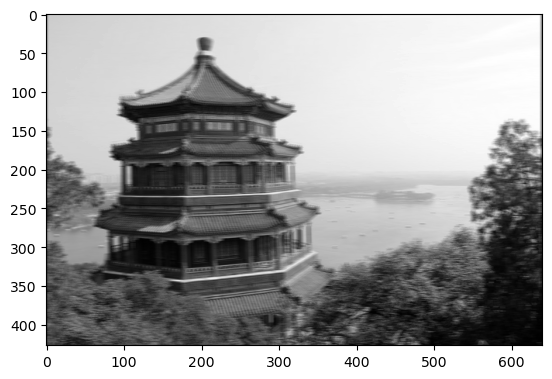

In [35]:
import numpy as np
images = np.array([china, flower])

batch_size, height, width, channels = images.shape

images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)

filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

import matplotlib.pyplot as plt

import tensorflow as tf

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.show

In [36]:
from tensorflow import keras

In [37]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

In [38]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [57]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides = strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [58]:
model = keras.models.Sequential()

In [59]:
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))

In [60]:
model.add(keras.layers.BatchNormalization())

In [61]:
model.add(keras.layers.Activation("relu"))

In [62]:
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

In [63]:
prev_filters = 64

In [64]:
for filters in [64] * 3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

In [67]:
model.add(keras.layers.GlobalAvgPool2D())

In [68]:
model.add(keras.layers.Flatten())

In [69]:
model.add(keras.layers.Dense(100, activation="softmax"))

In [70]:
import tensorflow_datasets as tfds

In [71]:
dataset, info = tfds.load("tf_flowers", as_supervised = True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\User\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [72]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='C:\\Users\\User\\tensorflow_datasets\\tf_flowers\\3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [73]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [76]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

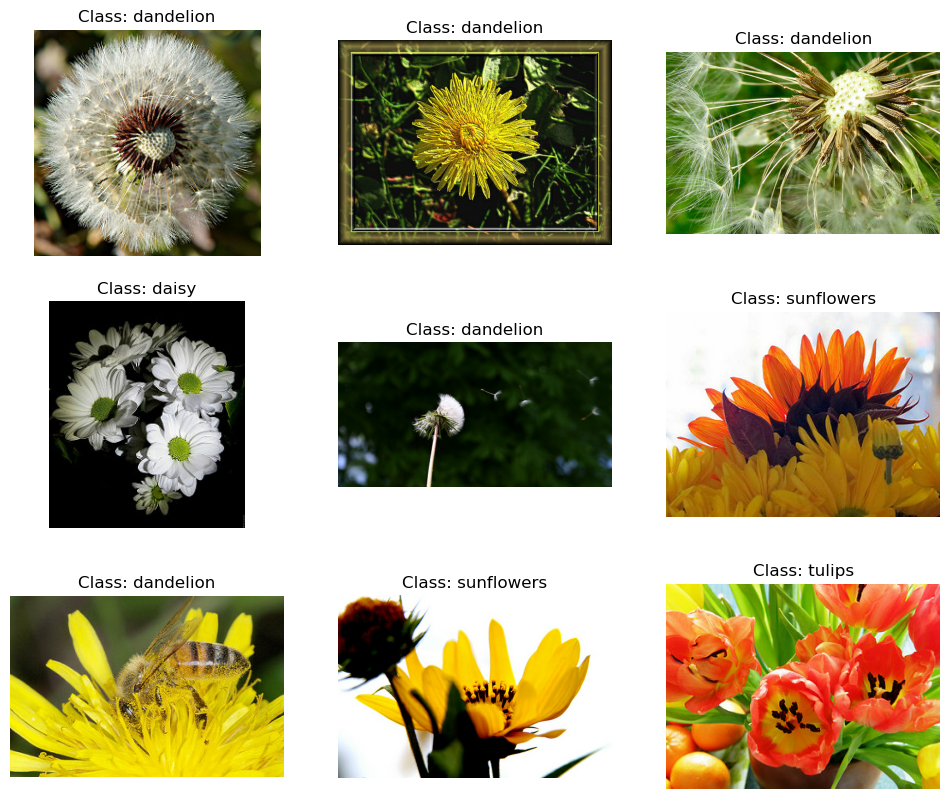

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index+=1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    
plt.show()

In [83]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [84]:
batch_size = 32

In [85]:
train_set = train_set_raw.shuffle(1000)
train_set = train_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [87]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [88]:
for layer in base_model.layers:
    layer.trainable = False

In [91]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)

In [95]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [96]:
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 90s 1s/step - loss: 1.4932 - accuracy: 0.7925 - val_loss: 1.2563 - val_accuracy: 0.7985
Epoch 2/5
86/86 [==============================] - 83s 967ms/step - loss: 0.6023 - accuracy: 0.8983 - val_loss: 0.9182 - val_accuracy: 0.8566
Epoch 3/5
86/86 [==============================] - 83s 963ms/step - loss: 0.2643 - accuracy: 0.9371 - val_loss: 0.7765 - val_accuracy: 0.8730
Epoch 4/5
86/86 [==============================] - 83s 962ms/step - loss: 0.1410 - accuracy: 0.9615 - val_loss: 0.6903 - val_accuracy: 0.8693
Epoch 5/5
86/86 [==============================] - 83s 966ms/step - loss: 0.0931 - accuracy: 0.9706 - val_loss: 0.7232 - val_accuracy: 0.8693


In [97]:
for layer in base_model.layers:
    layer.trainable = True
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)

In [98]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [99]:
model.fit(test_set, epochs=5, validation_data=valid_set)

Epoch 1/5
12/12 [==============================] - 77s 6s/step - loss: 0.7820 - accuracy: 0.7984 - val_loss: 1.1542 - val_accuracy: 0.8094
Epoch 2/5
12/12 [==============================] - 76s 6s/step - loss: 0.1792 - accuracy: 0.9700 - val_loss: 2.0206 - val_accuracy: 0.7623
Epoch 3/5
12/12 [==============================] - 69s 6s/step - loss: 0.0150 - accuracy: 0.9946 - val_loss: 2.1666 - val_accuracy: 0.7604
Epoch 4/5
12/12 [==============================] - 73s 6s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.9593 - val_accuracy: 0.7786
Epoch 5/5
12/12 [==============================] - 69s 6s/step - loss: 5.6012e-04 - accuracy: 1.0000 - val_loss: 1.7091 - val_accuracy: 0.7931


In [5]:
import tensorflow_datasets as tfds

In [6]:
dataset, info = tfds.load("mnist", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to C:\Users\User\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [8]:
dataset

{Split('train'): <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [29]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\User\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

4
(28, 28, 1)
()
1
(28, 28, 1)
()


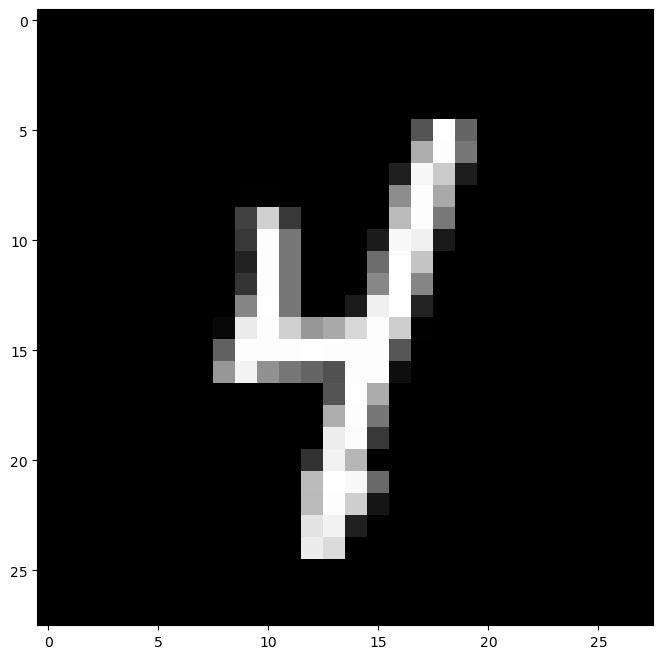

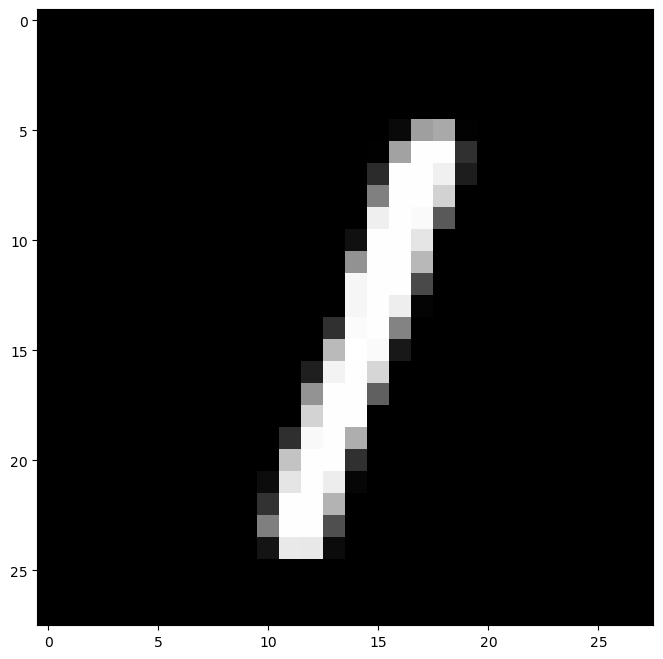

In [53]:

import matplotlib.pyplot as plt
j = 0
for i in dataset["train"]:
    print(i[1].numpy())
    image=i[0].numpy()
    label=i[1].numpy()
    print(image.shape)
    print(label.shape)
    plt.figure(figsize=(12, 8))
    plt.imshow(image, cmap="gray")
    j += 1
    if j > 1:
        break

In [108]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar os pixels
    image = tf.ensure_shape(image, [28, 28, 1])
    return image, label

In [109]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "mnist",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [110]:
for image, label in train_set_raw.take(1):  # Apenas para pegar o primeiro elemento
    print(image.shape)  # Imprime a forma da imagem
    print(label.shape) 

(28, 28, 1)
()


In [111]:
import tensorflow as tf
for image, label in train_set_raw.take(1):
    processed_image, processed_label = preprocess(image, label)
    print("Formato da imagem processada:", processed_image.shape)

Formato da imagem processada: (28, 28, 1)


In [112]:
batch_size = 32
train_set = train_set_raw.map(preprocess).batch(batch_size)
test_set = test_set_raw.map(preprocess).batch(batch_size)
valid_set = valid_set_raw.map(preprocess).batch(batch_size)

In [113]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 3, strides=1, padding="same", activation="relu", input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    
    keras.layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
    
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [114]:
model.fit(train_set, validation_data=valid_set, epochs=20, verbose=True, batch_size=32)

Epoch 1/20
1407/1407 [==============================] - 23s 16ms/step - loss: 0.1378 - accuracy: 0.9566 - val_loss: 0.0627 - val_accuracy: 0.9816
Epoch 2/20
1407/1407 [==============================] - 23s 16ms/step - loss: 0.0421 - accuracy: 0.9865 - val_loss: 0.0605 - val_accuracy: 0.9827
Epoch 3/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.0274 - accuracy: 0.9913 - val_loss: 0.0578 - val_accuracy: 0.9851
Epoch 4/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0505 - val_accuracy: 0.9880
Epoch 5/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.0619 - val_accuracy: 0.9872
Epoch 6/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.0678 - val_accuracy: 0.9857
Epoch 7/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.0641 -

In [117]:
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

188/188 [==============================] - 1s 5ms/step - loss: 0.0720 - accuracy: 0.9887


In [192]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [193]:
dataset, info = tfds.load("tf_flowers", with_info=True, as_supervised=True)

# Extrair informações
dataset_size = info.splits["train"].num_examples  # 3670
n_classes = info.features["label"].num_classes  # 5
class_names = info.features["label"].names

# Dividir o conjunto de dados
test_raw_set, valid_raw_set, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True  # Garante pares (image, label)
)

In [194]:

batch_size = 32

# Preparar os conjuntos de dados
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_raw_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_raw_set.map(preprocess).batch(batch_size).prefetch(1)

In [195]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [196]:
for layer in base_model.layers:
    layer.trainable = False

In [197]:
optimizer= tf.keras.optimizers.SGD(learning_rate=0.2, momentum = 0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 [==============================] - 83s 951ms/step - loss: 1.8501 - accuracy: 0.7922 - val_loss: 1.3189 - val_accuracy: 0.8330
Epoch 2/5
86/86 [==============================] - 82s 953ms/step - loss: 0.6933 - accuracy: 0.8968 - val_loss: 1.0798 - val_accuracy: 0.8548
Epoch 3/5
86/86 [==============================] - 82s 951ms/step - loss: 0.2991 - accuracy: 0.9368 - val_loss: 0.9263 - val_accuracy: 0.8711
Epoch 4/5
86/86 [==============================] - 82s 958ms/step - loss: 0.1905 - accuracy: 0.9560 - val_loss: 0.9210 - val_accuracy: 0.8639
Epoch 5/5
86/86 [==============================] - 86s 1s/step - loss: 0.1054 - accuracy: 0.9709 - val_loss: 0.8265 - val_accuracy: 0.8657


In [200]:
for layer in base_model.layers:
    layer.trainable = True

In [201]:
optimizer= tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 [==============================] - 426s 5s/step - loss: 1.0240 - accuracy: 0.6384 - val_loss: 106.7968 - val_accuracy: 0.2160
Epoch 2/5
86/86 [==============================] - 424s 5s/step - loss: 0.5541 - accuracy: 0.8041 - val_loss: 1.5867 - val_accuracy: 0.6860
Epoch 3/5
86/86 [==============================] - 439s 5s/step - loss: 0.3577 - accuracy: 0.8786 - val_loss: 0.4891 - val_accuracy: 0.8385
Epoch 4/5
86/86 [==============================] - 395s 5s/step - loss: 0.2473 - accuracy: 0.9117 - val_loss: 0.5527 - val_accuracy: 0.8421
Epoch 5/5
86/86 [==============================] - 438s 5s/step - loss: 0.1646 - accuracy: 0.9419 - val_loss: 0.5796 - val_accuracy: 0.8004
